This notebook brings together all the pieces about cross-validation and hyperparameter tuning with SMOTE.<br>
1. Subsampled 15 percent of the imbalanced train data (22 features) to use for cross-validation
2. Defined a function for cross-validation with upsampling using SMOTE on TRAIN folds ONLY
3. Wrote a loop to perform a search over a dictionary of desired parameters (80 combinations of parameters)
4. Identified the best combination of parameters using balanced accuracy as the main metric:
{'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 2}

5. Trained Random Forest on the full balanced train set with the best set of parameters and achieved 72.68% balanced accuracy
6. Exported the best model. Weights are available [here](https://drive.google.com/file/d/1oDon-QV8y4WR9tJfUGwvk_ucY-tijqBh/view?usp=share_link)


### Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from time import process_time

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score 

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
print(imblearn.__version__)

0.10.1


### Download the Dataset

In [2]:
# getting the cleaned data from the personal Google Drive
# !gdown '1bFPcr699XpzMVG45T9xlv4rIaan74_Ch' -O train_imbalanced.csv
!gdown '1ICZUG9vdJKSWjS1Ojr_Vb3VKgONeTXX1' -O train_imbalanced_85.csv
!gdown '1F1mHLwlno3OOtpSpMsiQqhoow6aj__DN' -O test_imbalanced_15.csv

Downloading...
From: https://drive.google.com/uc?id=1ICZUG9vdJKSWjS1Ojr_Vb3VKgONeTXX1
To: /content/train_imbalanced_85.csv
100% 237M/237M [00:01<00:00, 171MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F1mHLwlno3OOtpSpMsiQqhoow6aj__DN
To: /content/test_imbalanced_15.csv
100% 41.8M/41.8M [00:00<00:00, 189MB/s]


In [3]:
# train = pd.read_csv('../data/train_imbalanced_85.csv') # local
# test = pd.read_csv('../data/test_imbalanced_15.csv') # local

In [4]:
train = pd.read_csv('train_imbalanced_85.csv') # 22 features Colab
test = pd.read_csv('test_imbalanced_15.csv') # Colab

In [5]:
# removing labels from the train and test sets, also removing spkts column due to high correlation
X_train = train.drop(['attack_cat_code'], axis=1)
X_test = test.drop(['attack_cat_code'], axis=1)

# creating a dataframe for the target
y_train = train['attack_cat_code']
y_test = test['attack_cat_code']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2158774, 22), (2158774,), (380961, 22), (380961,))

In [6]:
y_train.value_counts()

0    1885684
1     183159
2      37846
3      20609
4      13900
5      11889
6       2275
7       1980
8       1284
9        148
Name: attack_cat_code, dtype: int64

### 1. Subsampling the dataset for faster parameter search
To speed up the training hyperparameter tunning will be performed using only 10% of the training data 

In [7]:
len(y_train)

2158774

In [8]:
# splitting the train set into train and val. setting the desired ratio to 15%
# X_gs and y_gs will be used for cross-validation -
X_train_sub, X_gs, y_train_sub, y_gs = train_test_split(X_train, y_train, random_state=33, test_size=0.15)
X_gs.shape, y_gs.shape

((323817, 22), (323817,))

In [9]:
# Standardizing
stdsc = StandardScaler()
X_gs_std = stdsc.fit_transform(X_gs)
X_test_std = stdsc.transform(X_test)

In [10]:
X_gs_std.shape, y_gs.shape, X_test_std.shape

((323817, 22), (323817,), (380961, 22))

### 2. Cross-Validation

In [11]:
def smote_cross_val(model, params, X, y, cv = None):
    """
    Creates folds manually, a
    nd upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    X = np.array(X)
    y = np.array(y)
    
    if cv is None:
        cv = StratifiedKFold(shuffle=True) # n_splits=5 is default

    scores = []
    models = []
    cnt = 1

    # get split indeces from the skf.splits
    for train_idx, val_idx in cv.split(X, y):
#         print(f'Fold #{cnt}')
#         print(train_idx, val_idx)
#         print(len(train_idx), len(val_idx))


        # Use indices to get training folds
        X_train_fold, y_train_fold = X[train_idx], y[train_idx]
        
        # Use indices to get validation folds. DO NOT touch until predict
        X_val_fold, y_val_fold = X[val_idx], y[val_idx]


        # get count of unique labels in the training fold
        unique, counts = np.unique(y_train_fold, return_counts=True)
        counts = dict(zip(unique, counts))
#         print(f'Original counts:\n{counts}') # {0: 29600, 1: 15097, 2: 8905, 3: 4850, 4: 3271, 5: 2797, 6: 542, 7: 467, 8: 302, 9: 35}

        # GET INITIAL LABEL COUNT
        # get the count for the second largest label of #1 
        # this will be the target ratio for upsamling the resto of the labels
        zero = counts[0] 
        one = counts[1]
        target_ratio = {0: zero,
                      1: one,
                      2: one,
                      3: one,
                      4: one,
                      5: one,
                      6: one,
                      7: one, 
                      8: one,
                      9: one }

        # print(zero, one)
#         print(f'SMOTE target ratio:\n{target_ratio}')
        # create SMOTE object
        sm = SMOTE(sampling_strategy = target_ratio)

        # APPLY SMOTE on the train folds
        X_train_smote, y_train_smote = sm.fit_resample(X_train_fold,
                                                      y_train_fold)

        # Confirm counts of unique labels in the training fold after SMOTE
        # unique_sm, counts_sm = np.unique(y_train_smote, return_counts=True)
        # counts_sm = dict(zip(unique_sm, counts_sm))
        # print(counts_sm)

        # UNDERSAMPLE the majority class to match the rest of the labels
        rus = RandomUnderSampler(sampling_strategy = 'not minority',
                               replacement = False)

        X_train_resampled, y_train_resampled = rus.fit_resample(X_train_smote, y_train_smote)
#         print(f'Undersampling Majority Class:\n{sorted(Counter(y_train_resampled).items())}')

        # Fit the model to the balanced training fold after SMOTE and undersampling
        model_obj = model(**params).fit(X_train_resampled, 
                                      y_train_resampled)

        # Score the model on the original val data (no SMOTE)
        score = balanced_accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
#         print(f'Balanced accuracy: {score}\n')

        scores.append(score)
        models.append(model_obj)
        cnt += 1
    
    return np.array(scores), models

In [12]:
# current_param_set = {'n_estimators': 100}

# scores, models = smote_cross_val(RandomForestClassifier,
#                                  current_param_set,
#                                  X_gs_std,
#                                  y_gs)

### 3 Hyperparameter Tuning with Grid-Search (larger set of parameters)


 #### Get combinations of parameters to test

In [13]:
def get_param_combos(dict_):
  '''
  pass a dictionary of parameters to get 
  a list of possible combinations to go over
  '''
                     

  dict_ = param_set
  keys = list(dict_.keys())
  total_params = len(dict_) # number of keys in the param dict

  param_set_combinations = []

  cnt=1
  # if 4  types of parameters in the dict_
  if total_params == 1:
    for param in dict_[keys[0]]:
      current_param_set = {
          keys[0]: param
          }
      # append to the param_set_combinations
      param_set_combinations.append(current_param_set)
      # print(cnt, current_param_set)
      # cnt+=1

  # 2 PARAMs BLOCK
  elif total_params == 2:
    for param in dict_[keys[0]]:
      for param2 in dict_[keys[1]]:
        current_param_set = {
                keys[0]: param,
                keys[1]: param2
                }
        # append to the param_set_combinations
        param_set_combinations.append(current_param_set)
        # print(cnt, current_param_set)
        # cnt+=1
  # 3 PARAMs BLOCK
  elif total_params == 3:
    for param in dict_[keys[0]]:
      for param2 in dict_[keys[1]]:
        for param3 in dict_[keys[2]]:  
          current_param_set = {
                  keys[0]: param,
                  keys[1]: param2,
                  keys[2]: param3
                  }
          # append to the param_set_combinations
          param_set_combinations.append(current_param_set)
          # print(cnt, current_param_set)
          # cnt+=1

  # 4 PARAMs BLOCK
  elif total_params ==4:
    for param in dict_[keys[0]]:
      for param2 in dict_[keys[1]]:
        for param3 in dict_[keys[2]]:
          for param4 in dict_[keys[3]]:
            current_param_set = {
                    keys[0]: param,
                    keys[1]: param2,
                    keys[2]: param3,
                    keys[3]: param4
                    }
            # append to the param_set_combinations
            param_set_combinations.append(current_param_set)
            # print(cnt, current_param_set)
            # cnt+=1
  return param_set_combinations

In [49]:
param_set = {
    # Number of trees 
    'n_estimators': [100, 200, 300, 400, 500,1000],
    # Minimum number of samples required to split a node
    'min_samples_split': [2,3],
    # Maximum number of levels in tree
    'max_depth': [None, 5, 10, 20],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [1,2]

}

In [50]:
param_set_combinations = get_param_combos(param_set)
len(param_set_combinations)

96

##### Recreating score_tracker in text form after execution was interrupted

Set #1. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 374.09405316899995
Avg balanced accuracy: 0.6276903850296522

Set #2. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 360.96151360199997
Avg balanced accuracy: 0.6438976359908665

Set #3. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 162.76814545699995
Avg balanced accuracy: 0.6783116330750085

Set #4. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 158.34734048399991
Avg balanced accuracy: 0.6740580375336556

Set #5. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 246.30935170099997
Avg balanced accuracy: 0.6910132264836163

Set #6. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 2}
Running time: 246.72477455099988
Avg balanced accuracy: 0.6928759012756311

Set #7. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 1}
Running time: 347.43607212300003
Avg balanced accuracy: 0.6415123771899893

Set #8. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 2}
Running time: 338.29599659999985
Avg balanced accuracy: 0.6492191321073951

Set #9. Params: {'n_estimators': 100, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 369.4834521120001
Avg balanced accuracy: 0.6298011435170905

Set #10. Params: {'n_estimators': 100, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 352.832800014
Avg balanced accuracy: 0.6533579183276268

Set #11. Params: {'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 162.50940536000007
Avg balanced accuracy: 0.6799652606871628

Set #12. Params: {'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 157.04441390400007
Avg balanced accuracy: 0.6759612609261804

Set #13. Params: {'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 240.18507602999944
Avg balanced accuracy: 0.6886019736774451

Set #14. Params: {'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 2}
Running time: 240.3066240779999
Avg balanced accuracy: 0.6907601516106139

Set #15. Params: {'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 1}
Running time: 345.22669527000016
Avg balanced accuracy: 0.6491505773309958

Set #16. Params: {'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 2}
Running time: 336.5618073220003
Avg balanced accuracy: 0.6666528081297977

Set #17. Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 724.7979220139996
Avg balanced accuracy: 0.6290723858748859

Set #18. Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 712.416204049
Avg balanced accuracy: 0.6441980254097062

Set #19. Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 314.22188001299946
Avg balanced accuracy: 0.6850221488899002

Set #20. Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 313.349664716
Avg balanced accuracy: 0.6742065420982923

Set #21. Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 501.1512583049998
Avg balanced accuracy: 0.6879985489549252

Set #22. Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 2}
Running time: 501.45546308400026
Avg balanced accuracy: 0.686074609238762

Set #23. Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 1}
Running time: 679.9209216349991
Avg balanced accuracy: 0.6541872701312107

Set #24. Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 2}
Running time: 664.7061189830001
Avg balanced accuracy: 0.6635742840913083

Set #25. Params: {'n_estimators': 200, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 722.6392026779995
Avg balanced accuracy: 0.628107570914443

Set #26. Params: {'n_estimators': 200, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 707.4803666000007
Avg balanced accuracy: 0.6517261311128608

Set #27. Params: {'n_estimators': 200, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 315.0902155800013
Avg balanced accuracy: 0.6782705623301468

Set #28. Params: {'n_estimators': 200, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 317.6933623730001
Avg balanced accuracy: 0.6759088455027666

Set #29. Params: {'n_estimators': 200, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 486.3737038849995
Avg balanced accuracy: 0.6889050320253453

Set #30. Params: {'n_estimators': 200, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 2}
Running time: 478.9405487210006
Avg balanced accuracy: 0.6917183739524294

Set #31. Params: {'n_estimators': 200, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 1}
Running time: 666.6250665899988
Avg balanced accuracy: 0.6453915420885483

Set #32. Params: {'n_estimators': 200, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 2}
Running time: 657.138248397001
Avg balanced accuracy: 0.6604035588685184

Set #33. Params: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 1059.268977392001
Avg balanced accuracy: 0.6278316529338841

Set #34. Params: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 1040.2117054209994
Avg balanced accuracy: 0.6496093516949987

Set #35. Params: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 457.23802124800204
Avg balanced accuracy: 0.6751591387027289

Set #36. Params: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 446.38330191899877
Avg balanced accuracy: 0.671353337012029

Set #37. Params: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 694.2585332439994
Avg balanced accuracy: 0.698978458857947

Set #38. Params: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 2}
Running time: 686.5984552000009
Avg balanced accuracy: 0.6919936232835332

Set #39. Params: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 1}
Running time: 998.4138463059971
Avg balanced accuracy: 0.6398668329721119

Set #40. Params: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 2}
Running time: 1003.0730402640002
Avg balanced accuracy: 0.6515512645627742

Set #41. Params: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 1101.1532773809995
Avg balanced accuracy: 0.6274122674299887

Set #42. Params: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 1052.9149707569995
Avg balanced accuracy: 0.6419440161696929

Set #43. Params: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 478.9616722539977
Avg balanced accuracy: 0.6811664476279675

Set #44. Params: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 469.7680346950001
Avg balanced accuracy: 0.6686887072076795

Set #45. Params: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 721.1728486219981
Avg balanced accuracy: 0.6887758084629475

Set #46. Params: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 2}
Running time: 716.6027595620035
Avg balanced accuracy: 0.6995605335161759

Set #47. Params: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 1}
Running time: 1003.702723792001
Avg balanced accuracy: 0.6587759675183236

Set #48. Params: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 2}
Running time: 1001.8894239610017
Avg balanced accuracy: 0.6536835598235997

Set #49. Params: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 1447.371128103001
Avg balanced accuracy: 0.6371578135243909

Set #50. Params: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 1427.0102525090006
Avg balanced accuracy: 0.6412561172053779

Set #51. Params: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 620.1665657599988
Avg balanced accuracy: 0.6818600025170919

Set #52. Params: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 596.8421582390001
Avg balanced accuracy: 0.6727207302302695

Set #53. Params: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 943.6770828549998
Avg balanced accuracy: 0.6968593609114598

Set #54. Params: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 2}
Running time: 947.2361782370026
Avg balanced accuracy: 0.6935482682802243

Set #55. Params: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 1}
Running time: 1338.4319174880002
Avg balanced accuracy: 0.6400356725319145

Set #56. Params: {'n_estimators': 400, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 2}
Running time: 1326.078856745
Avg balanced accuracy: 0.6577975442707056

Set #57. Params: {'n_estimators': 400, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 1450.013755312997
Avg balanced accuracy: 0.6418751410006528

Set #58. Params: {'n_estimators': 400, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 1405.4404485230043
Avg balanced accuracy: 0.6463364321598651

Set #59. Params: {'n_estimators': 400, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 606.4247355159969
Avg balanced accuracy: 0.676504351446534

Set #60. Params: {'n_estimators': 400, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 595.9878427400035
Avg balanced accuracy: 0.6773823386498071

Set #61. Params: {'n_estimators': 400, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 952.8766829710003
Avg balanced accuracy: 0.6859159144569221

Set #62. Params: {'n_estimators': 400, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 2}
Running time: 962.668900951001
Avg balanced accuracy: 0.6982817794486234

Set #63. Params: {'n_estimators': 400, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 1}
Running time: 1356.3215252890004
Avg balanced accuracy: 0.6465333054364301

Set #64. Params: {'n_estimators': 400, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 2}
Running time: 1313.1381030050034
Avg balanced accuracy: 0.6581216214300835

Set #65. Params: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 1805.528343486003
Avg balanced accuracy: 0.6294780898819543

Set #66. Params: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 1801.650405732
Avg balanced accuracy: 0.6335968055760031

Set #67. Params: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 767.5430376950003
Avg balanced accuracy: 0.6747774539932622

Set #68. Params: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 789.1678652549999
Avg balanced accuracy: 0.6815915321401846

Set #69. Params: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 1235.931169428
Avg balanced accuracy: 0.6834776894354478

Set #70. Params: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 2}
Running time: 1221.9120769729998
Avg balanced accuracy: 0.6984609188966582

Set #71. Params: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 1}
Running time: 1739.4586767230003
Avg balanced accuracy: 0.6441044513195766

Set #72. Params: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 2}
Running time: 1685.455815403001
Avg balanced accuracy: 0.6442258421477731

Set #73. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 1872.193593937
Avg balanced accuracy: 0.63660909286274

Set #74. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 1822.382917489
Avg balanced accuracy: 0.6451936032796686

Set #75. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 795.3577131079996
Avg balanced accuracy: 0.6731137864302188

Set #76. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 791.5836899139995
Avg balanced accuracy: 0.6772018358194207

Set #77. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 1240.9863157379996
Avg balanced accuracy: 0.6944400480539433

Set #78. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 2}
Running time: 1235.7908969890004
Avg balanced accuracy: 0.6888597963896601

Set #79. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 1}
Running time: 1762.2749730490004
Avg balanced accuracy: 0.6470361639045924

Set #80. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 20, 'min_samples_leaf': 2}
Running time: 1739.3023663050008
Avg balanced accuracy: 0.6565203577807195

##### Recreating results

In [51]:
acc_lst = [0.627690385029652,0.643897635990866,0.678311633075008,0.674058037533655,0.691013226483616,0.692875901275631,0.641512377189989,0.649219132107395,0.62980114351709,0.653357918327626,0.679965260687162,0.67596126092618,0.688601973677445,0.690760151610613,0.649150577330995,0.666652808129797,0.629072385874885,0.644198025409706,0.6850221488899,0.674206542098292,0.687998548954925,0.686074609238762,0.65418727013121,0.663574284091308,0.628107570914443,0.65172613111286,0.678270562330146,0.675908845502766,0.688905032025345,0.691718373952429,0.645391542088548,0.660403558868518,0.627831652933884,0.649609351694998,0.675159138702728,0.671353337012029,0.698978458857947,0.691993623283533,0.639866832972111,0.651551264562774,0.627412267429988,0.641944016169692,0.681166447627967,0.668688707207679,0.688775808462947,0.699560533516175,0.658775967518323,0.653683559823599,0.63715781352439,0.641256117205377,0.681860002517091,0.672720730230269,0.696859360911459,0.693548268280224,0.640035672531914,0.657797544270705,0.641875141000652,0.646336432159865,0.676504351446534,0.677382338649807,0.685915914456922,0.698281779448623,0.64653330543643,0.658121621430083,0.629478089881954,0.633596805576003,0.674777453993262,0.681591532140184,0.683477689435447,0.698460918896658,0.644104451319576,0.644225842147773,0.63660909286274,0.645193603279668,0.673113786430218,0.67720183581942,0.694440048053943,0.68885979638966,0.647036163904592,0.656520357780719]

In [52]:
score_tracker2 = []

cnt = 0
while len(param_set_combinations) > 16:
  current_param_set = param_set_combinations.pop(0)
  print(f'Set #{cnt+1}. Params: {current_param_set}')
  score_tracker2.append(current_param_set)
  current_param_set['balanced_accuracy'] = acc_lst[cnt]
  cnt+=1


print(len(param_set_combinations), len(score_tracker2), (len(param_set_combinations)+ len(score_tracker2)))

Set #1. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 1}
Set #2. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None, 'min_samples_leaf': 2}
Set #3. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 1}
Set #4. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 2}
Set #5. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 1}
Set #6. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 2}
Set #7. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 1}
Set #8. Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 2}
Set #9. Params: {'n_estimators': 100, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 1}
Set #10. Params: {'n_estimators': 100, 'min_samples_split': 3, 'max_depth': No

In [53]:
score_tracker

[{'n_estimators': 500,
  'min_samples_split': 3,
  'max_depth': None,
  'min_samples_leaf': 1,
  'balanced_accuracy': 0.63660909286274},
 {'n_estimators': 500,
  'min_samples_split': 3,
  'max_depth': None,
  'min_samples_leaf': 2,
  'balanced_accuracy': 0.6451936032796686},
 {'n_estimators': 500,
  'min_samples_split': 3,
  'max_depth': 5,
  'min_samples_leaf': 1,
  'balanced_accuracy': 0.6731137864302188},
 {'n_estimators': 500,
  'min_samples_split': 3,
  'max_depth': 5,
  'min_samples_leaf': 2,
  'balanced_accuracy': 0.6772018358194207},
 {'n_estimators': 500,
  'min_samples_split': 3,
  'max_depth': 10,
  'min_samples_leaf': 1,
  'balanced_accuracy': 0.6944400480539433},
 {'n_estimators': 500,
  'min_samples_split': 3,
  'max_depth': 10,
  'min_samples_leaf': 2,
  'balanced_accuracy': 0.6888597963896601},
 {'n_estimators': 500,
  'min_samples_split': 3,
  'max_depth': 20,
  'min_samples_leaf': 1,
  'balanced_accuracy': 0.6470361639045924},
 {'n_estimators': 500,
  'min_samples_spl

In [ ]:
# score_tracker2

##### Continuing grid search

In [40]:
param_set_combinations = param_set_combinations[:8]

In [42]:
score_tracker = []
# cnt = 1
cnt = 73
while param_set_combinations:
  # remove the first element
  current_param_set = param_set_combinations.pop(0)
  print(f'Set #{cnt}. Params: {current_param_set}')

  start_time = process_time()
  # run cross-validation

  
  scores, models = smote_cross_val(RandomForestClassifier,
                                   current_param_set, 
                                   X_gs_std,
                                   y_gs)
  time_to_run = process_time() - start_time
  print(f'Running time: {time_to_run}')

  # get average score from cross-validation
  avg_score = scores.mean()

  # record it in the current param set
  current_param_set['balanced_accuracy'] = avg_score
  print(f'Avg balanced accuracy: {avg_score}\n')

  # append current_param_set to the list
  score_tracker.append(current_param_set)
  # increment the count
  cnt+=1

Set #73. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 1}
Running time: 1872.193593937
Avg balanced accuracy: 0.63660909286274

Set #74. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 2}
Running time: 1822.382917489
Avg balanced accuracy: 0.6451936032796686

Set #75. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 1}
Running time: 795.3577131079996
Avg balanced accuracy: 0.6731137864302188

Set #76. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 5, 'min_samples_leaf': 2}
Running time: 791.5836899139995
Avg balanced accuracy: 0.6772018358194207

Set #77. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 1}
Running time: 1240.9863157379996
Avg balanced accuracy: 0.6944400480539433

Set #78. Params: {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 2}
Running time

### 4. Get the Best Params

In [55]:
# top 5 params
sorted(score_tracker2, key=lambda x: x['balanced_accuracy'], reverse=True)[:10]

[{'n_estimators': 300,
  'min_samples_split': 3,
  'max_depth': 10,
  'min_samples_leaf': 2,
  'balanced_accuracy': 0.699560533516175},
 {'n_estimators': 300,
  'min_samples_split': 2,
  'max_depth': 10,
  'min_samples_leaf': 1,
  'balanced_accuracy': 0.698978458857947},
 {'n_estimators': 500,
  'min_samples_split': 2,
  'max_depth': 10,
  'min_samples_leaf': 2,
  'balanced_accuracy': 0.698460918896658},
 {'n_estimators': 400,
  'min_samples_split': 3,
  'max_depth': 10,
  'min_samples_leaf': 2,
  'balanced_accuracy': 0.698281779448623},
 {'n_estimators': 400,
  'min_samples_split': 2,
  'max_depth': 10,
  'min_samples_leaf': 1,
  'balanced_accuracy': 0.696859360911459},
 {'n_estimators': 500,
  'min_samples_split': 3,
  'max_depth': 10,
  'min_samples_leaf': 1,
  'balanced_accuracy': 0.694440048053943},
 {'n_estimators': 400,
  'min_samples_split': 2,
  'max_depth': 10,
  'min_samples_leaf': 2,
  'balanced_accuracy': 0.693548268280224},
 {'n_estimators': 100,
  'min_samples_split': 2,

In [56]:
# Get the parameters and the balanced accuracy of the best model
best_params_set = sorted(score_tracker2, key=lambda x: x['balanced_accuracy'], reverse=True)[0]
print(best_params_set)

# params to pass to the classifier (removing balanced accuracy)
best_params_rf = dict(best_params_set)
del best_params_rf['balanced_accuracy']
best_params_rf

{'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 10, 'min_samples_leaf': 2, 'balanced_accuracy': 0.699560533516175}


{'n_estimators': 300,
 'min_samples_split': 3,
 'max_depth': 10,
 'min_samples_leaf': 2}

### 5. Run with best params over full dataset (balanced with SMOTE)

In [57]:
!gdown '1ANWzAKy0MKpZsID16fNnrZ8ltmOYq8G3' -O train_balanced_85_multi_22_features.csv
!gdown '1F1mHLwlno3OOtpSpMsiQqhoow6aj__DN' -O test_imbalanced_15.csv

Downloading...
From: https://drive.google.com/uc?id=1ANWzAKy0MKpZsID16fNnrZ8ltmOYq8G3
To: /content/train_balanced_85_multi_22_features.csv
100% 231M/231M [00:46<00:00, 4.97MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F1mHLwlno3OOtpSpMsiQqhoow6aj__DN
To: /content/test_imbalanced_15.csv
100% 41.8M/41.8M [00:08<00:00, 4.99MB/s]


In [58]:
# Run in Colab
train = pd.read_csv('train_balanced_85_multi_22_features.csv')
test = pd.read_csv('test_imbalanced_15.csv')

In [ ]:
# # Local destination
# train = pd.read_csv('../data/train_balanced_85_multi_22_features.csv')
# test = pd.read_csv('../data/test_imbalanced_15.csv')

In [59]:
# removing labels from the train and test sets, also removing spkts column due to high correlation
X_train = train.drop(['attack_cat_code'], axis=1)
X_test = test.drop(['attack_cat_code'], axis=1)

# creating a dataframe for the target
y_train = train['attack_cat_code']
y_test = test['attack_cat_code']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1831590, 22), (1831590,), (380961, 22), (380961,))

In [60]:
y_train.value_counts()

0    183159
1    183159
2    183159
3    183159
4    183159
5    183159
6    183159
7    183159
8    183159
9    183159
Name: attack_cat_code, dtype: int64

In [61]:
# Standardizing
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

X_train_std.shape, y_train.shape, X_test_std.shape, y_test.shape

((1831590, 22), (1831590,), (380961, 22), (380961,))

In [62]:
start_time = process_time()
# instantiate the classifier
rf_best_params = RandomForestClassifier()
# pass the dictioanary with the best params determined by GridSearch
rf_best_params.set_params(**best_params_rf)
# fit the model
rf_best_params.fit(X_train_std, y_train)
time_to_train = process_time() - start_time
print(f'time to train: {time_to_train}')

start_time = process_time()
y_pred_rf_best_params = rf_best_params.predict(X_test_std)
time_to_train = process_time() - start_time
print(f'inference time: {time_to_train}')

time to train: 1286.0010581529987
inference time: 13.219265067000379


In [ ]:
# rf_best_params.get_params()

### Function to visualize confusion matrix and classification report

In [67]:
codes = {'Normal':0,
         'Generic':1,
         'Exploits':2,
         'Fuzzers': 3,
         'DoS':4,
         'Reconnaissance':5,
         'Analysis':6,
         'Backdoor':7,
         'Shellcode':8,
         'Worms':9   
}
labels = [x for x in codes.keys()]
# labels

# Function to visualize the performance
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def calculate_metrics(y_true, y_pred, labels):


    """
    Calculate main metrics:
    :param y_test - actual value
    :param y_pred - predicted value
    :param labels - class labels
    :return balanced_accuracy, accuracy, precision, recall, f1
    """
    accuracy = accuracy_score(y_true, y_pred)
    # The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. 
    # It is defined as the average of recall obtained on each class.
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)

    # tp / (tp + fp) Ability of the classifier not to label as positive a sample that is negative.
    precision = precision_score(y_true, y_pred, average='weighted')

    # tp / (tp + fn) Ability of the classifier to find all the positive samples.
    recall = recall_score(y_true, y_pred, average='weighted')

    # F1 = 2 * (precision * recall) / (precision + recall)
    # harmonic mean of the precision and recall
    f1 = f1_score(y_true, y_pred, average='weighted')


    print(f'Accuracy:{accuracy:.2f}')
    print(f'Balanced accuracy:{balanced_accuracy:.2f}')
    print(f'Precision:{precision:.2f}')
    print(f'Recall:{recall:.2f}')
    print(f'F1-score:{f1:.2f}') 

    cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

    fig, ax = plt.subplots(figsize=(9, 9))
    ax.set_title('Balanced Accuracy on Test Set: {0}%\n'.format("%.2f" % (balanced_accuracy*100.0)), size=14)
    ax.set_ylabel('Actual Label')
    ax.set_xlabel('Predicted Label')

    sns.heatmap(cnf_matrix,
              square=True,
              annot=True,
              cbar=False,
              fmt=".2f",
              linewidths=0.1,
              cmap="Greens",
              xticklabels=labels,
              yticklabels=labels,
              ax=ax)
    plt.tight_layout()
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.show()

    print('Classification Report:\n',
      classification_report(y_true,
                            y_pred,
                            target_names=labels))
    return accuracy, balanced_accuracy, precision, recall, f1 

Accuracy:0.97
Balanced accuracy:0.73
Precision:0.98
Recall:0.97
F1-score:0.97


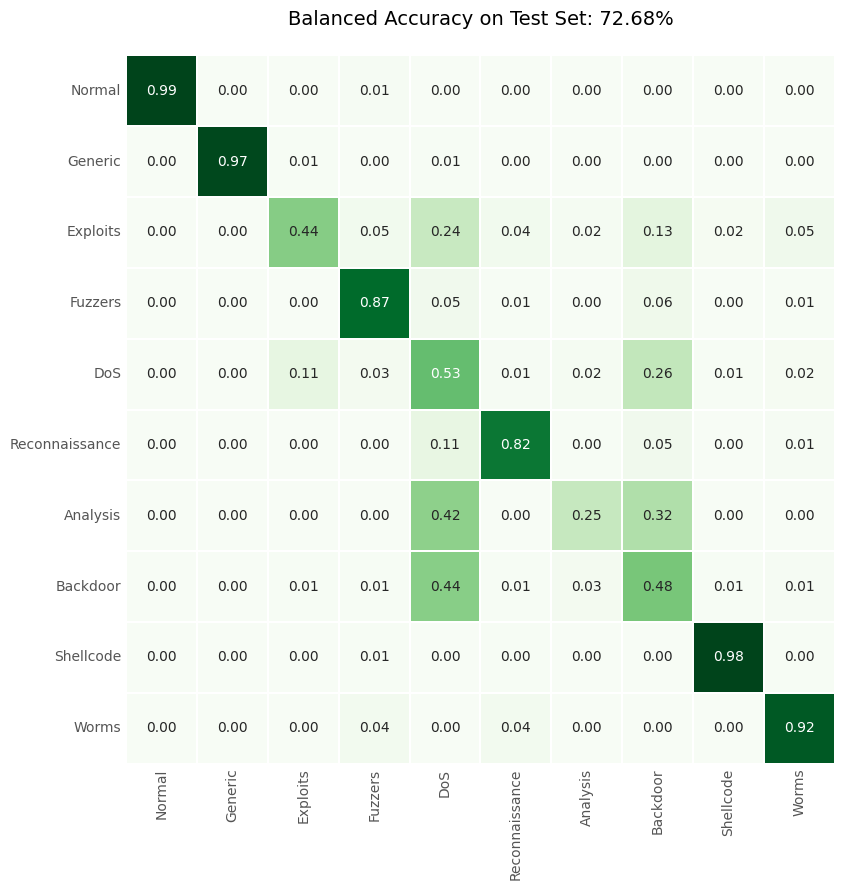

Classification Report:
                 precision    recall  f1-score   support

        Normal       1.00      0.99      0.99    332768
       Generic       1.00      0.97      0.99     32322
      Exploits       0.82      0.44      0.58      6679
       Fuzzers       0.42      0.87      0.56      3637
           DoS       0.34      0.53      0.41      2453
Reconnaissance       0.81      0.82      0.81      2098
      Analysis       0.12      0.25      0.16       402
      Backdoor       0.08      0.48      0.13       349
     Shellcode       0.49      0.98      0.66       227
         Worms       0.04      0.92      0.07        26

      accuracy                           0.97    380961
     macro avg       0.51      0.73      0.54    380961
  weighted avg       0.98      0.97      0.97    380961



(0.9692986946170343,
 0.7267500763500443,
 0.9838231432227574,
 0.9692986946170343,
 0.9743839693133561)

In [71]:
plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')
calculate_metrics(y_test, y_pred_rf_best_params, labels)

### 7. Export the best model

In [66]:
# Exporting the model
from joblib import dump, load
dump(rf_best_params, 'rf_best_params.joblib') 

['rf_best_params.joblib']

inference time: 13.509408955000254
Accuracy:0.97
Balanced accuracy:0.73
Precision:0.98
Recall:0.97
F1-score:0.97


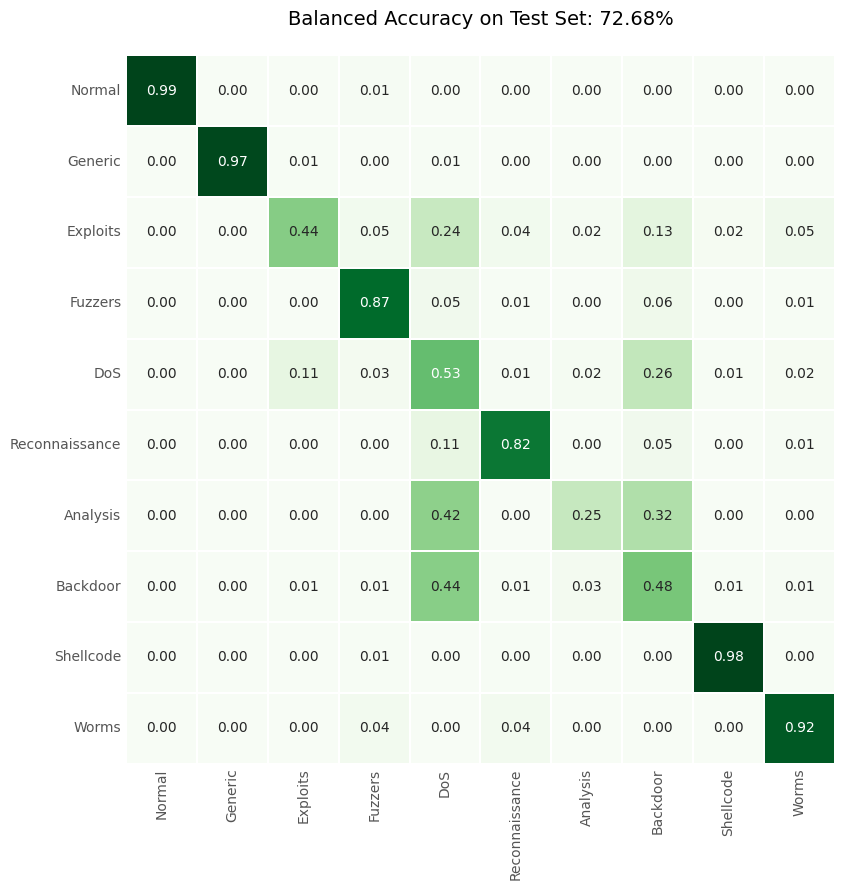

Classification Report:
                 precision    recall  f1-score   support

        Normal       1.00      0.99      0.99    332768
       Generic       1.00      0.97      0.99     32322
      Exploits       0.82      0.44      0.58      6679
       Fuzzers       0.42      0.87      0.56      3637
           DoS       0.34      0.53      0.41      2453
Reconnaissance       0.81      0.82      0.81      2098
      Analysis       0.12      0.25      0.16       402
      Backdoor       0.08      0.48      0.13       349
     Shellcode       0.49      0.98      0.66       227
         Worms       0.04      0.92      0.07        26

      accuracy                           0.97    380961
     macro avg       0.51      0.73      0.54    380961
  weighted avg       0.98      0.97      0.97    380961



(0.9692986946170343,
 0.7267500763500443,
 0.9838231432227574,
 0.9692986946170343,
 0.9743839693133561)

In [73]:
# loading to make sure the weights are OK
loaded_rf_best_params = load('rf_best_params.joblib')

start_time = process_time()
y_pred = loaded_rf_best_params.predict(X_test_std)
time_to_train = process_time() - start_time
print(f'inference time: {time_to_train}')
# visualizing
calculate_metrics(y_test, y_pred_rf_best_params, labels)